# Cross-correlation procedure in three steps

In [1]:
# Importing all libraries
import numpy
from time import time
from matplotlib import pyplot
from codes.prism import prism_tf
from codes.grids import regular_grid
from codes.plot import draw_prism
from codes.auxiliars import addnoise
from codes.statistical import analysis, cccoef
from codes.filtering import reduction
from codes.derivative import totalgrad, zderiv
from codes.equivalentlayer import layer, rtp_layer

In [2]:
# Defines number of points and area
nx, ny = 50, 50
area = (-2000., 2000., -2000., 2000.)
shape = (nx, ny)
xobs, yobs, zobs = regular_grid(area, shape, -100.)

### Here we are assuming that both dike models has the same magnetization direction

In [3]:
# Define the dike models
dike1 = [-1400., -500., -1000., -200., 100., 500., 1.715]
dike2 = [600., 1300., 600., 1700., 120., 970., 1.215]
# Directions
inc, dec = -23., -69. # field
incs, decs = 5., -3. # source

In [4]:
# Computes the total field anomaly
tf = prism_tf(xobs, yobs, zobs, dike1, inc, dec, incs, decs) + \
     prism_tf(xobs, yobs, zobs, dike2, inc, dec, incs, decs)

In [5]:
# Analyze the data
_ = analysis(tf, 'nT')

Minimum:    -186.8598 nT
Maximum:    122.2924 nT
Mean value: -7.1030 nT
Variation:  309.1521 nT


In [6]:
# Adding noise
tf = addnoise(tf, 5., 0.1)

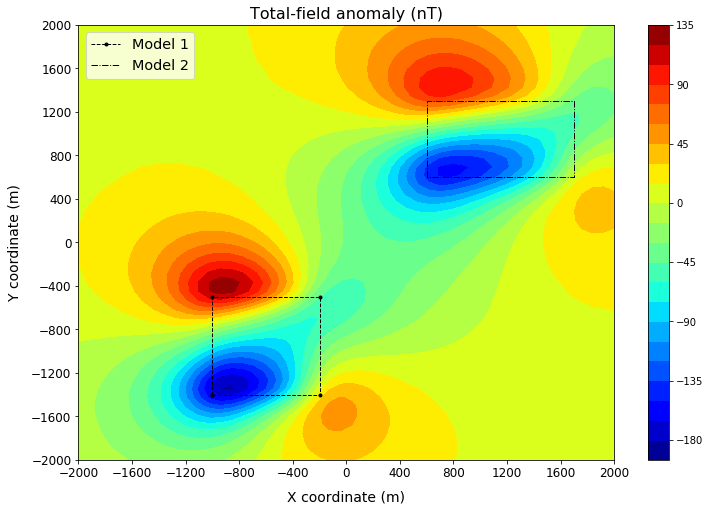

In [7]:
# Plotting the result
pyplot.figure(figsize=(12, 8))
pyplot.contourf(yobs.reshape(shape), xobs.reshape(shape), tf.reshape(shape), 
                20, cmap = pyplot.cm.jet)
# Draw the model edges
draw_prism(dike1[:4], linewidth=1., style = 'k.--' , label = 'Model 1', xy2ne=True)
draw_prism(dike2[:4], linewidth=1., style = 'k-.', label = 'Model 2', xy2ne=True)
pyplot.title('Total-field anomaly (nT)', fontsize = 16)
pyplot.xlabel('X coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('Y coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yobs.min(), yobs.max(), 11), fontsize = 12)
pyplot.yticks(numpy.linspace(xobs.min(), xobs.max(), 11), fontsize = 12)
pyplot.colorbar(orientation = 'vertical')
pyplot.legend(loc = 'upper left', fontsize = 'x-large')

pyplot.savefig('fig01-totalfieldanomaly.png', dpi = 300, bbox_inches = 'tight')
pyplot.show()

In [8]:
# Layer informations
area_layer = (-2000., 2000., -2000., 2000.)
shape_layer = (15, 15)
level = 800.

In [9]:
# Create the layer
eqlayer = layer(area_layer, shape_layer, level)

In [10]:
# Allocate all values as a list
data = [xobs, yobs, zobs, tf]

### Step 1 - Compute the cross-correlation coefficients at all negative values of inclination lower than $10^o$

In [11]:
# Create the grid
# For Fourier transformation
inclination1 = numpy.linspace(-90., -10., 81)
inclination2 = numpy.linspace(10., 90., 81)
declination = numpy.linspace(-180., 180., 361)

In [12]:
# Create the full grid
D1, I1 = numpy.meshgrid(declination, inclination1)
D2, I2 = numpy.meshgrid(declination, inclination2)

In [13]:
# Create the zero matrix
res1 = numpy.zeros_like(D1)
res2 = numpy.zeros_like(D2)

In [14]:
# Reshape the data as grid format
xobs = xobs.reshape(shape)
yobs = yobs.reshape(shape)
tf = tf.reshape(shape)

In [15]:
# Compute the time
initial = time()
for k2, d in enumerate(declination):
    for k1, i in enumerate(inclination1):
        rtp = reduction(xobs, yobs, tf, inc, dec, i, d)
        tga = totalgrad(xobs, yobs, rtp)
        vga = zderiv(xobs, yobs, rtp)
        res1[k1,k2] = cccoef(tga, vga)        
final = time()
print 'Cross correlation for positive range'
print 'Computation time (sec): %.3f' % (final-initial)

codes/auxiliars.py:207: RuntimeWarning: invalid value encountered in divide
  theta = z + ((x*u + y*v)/k)*1j


Cross correlation for positive range
Computation time (sec): 37.547


In [16]:
# Analysing the positive coefficients
print 'First cross-correlation:'
_ = analysis(res1, 'no unit')

First cross-correlation:
Minimum:    -0.5046 no unit
Maximum:    0.1514 no unit
Mean value: -0.2387 no unit
Variation:  0.6560 no unit


In [17]:
# Search for the maximum and minimum pair of inclination and declination
imax1, jmax1 = numpy.where(res1 == res1.max())
imin1, jmin1 = numpy.where(res1 == res1.min())
incmax1 = float(I1[imax1, jmax1])
decmax1 = float(D1[imax1, jmax1])
incmin1 = float(I1[imin1, jmin1])
decmin1 = float(D1[imin1, jmin1])
print 'Verify the computed correlation:'
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax1
print 'Declination:', decmax1
print
print '(I,D) for minimum coefficient:'
print 'Inclination:', incmin1
print 'Declination:', decmin1

Verify the computed correlation:
(I,D) for maximum coefficient
Inclination: -10.0
Declination: 95.0

(I,D) for minimum coefficient:
Inclination: -10.0
Declination: -141.0


/home/nielsendelimar/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


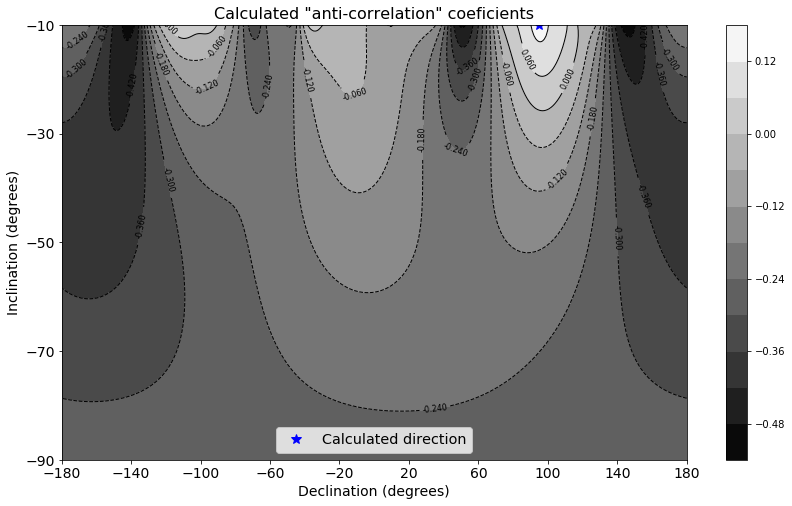

In [18]:
# Plotting the correlation results
pyplot.figure(figsize=(14, 8))

fig1 = pyplot.contour(D1, I1, res1, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(D1, I1, res1, 10, cmap = pyplot.cm.gray)
pyplot.clabel(fig1, fontsize = 8)
pyplot.plot(decmax1, incmax1, 'b*', markersize = 10, label = 'Calculated direction')
pyplot.rcParams['contour.negative_linestyle'] = 'solid'
pyplot.title('Calculated "anti-correlation" coeficients', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.linspace(D1.min(), D1.max(), 10), fontsize = 14)
pyplot.yticks(numpy.linspace(I1.min(), I1.max(), 5), fontsize = 14)
pyplot.legend(loc = 'lower center', fontsize = 'x-large')
pyplot.colorbar()
pyplot.savefig('fig02-first-correlation.png', dpi = 300, bbox_inches = 'tight')

pyplot.show()

In [19]:
# Computes the reduced data by equivalent layer (space domain)
rtp1_eqlayer = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, incmax1, decmax1)

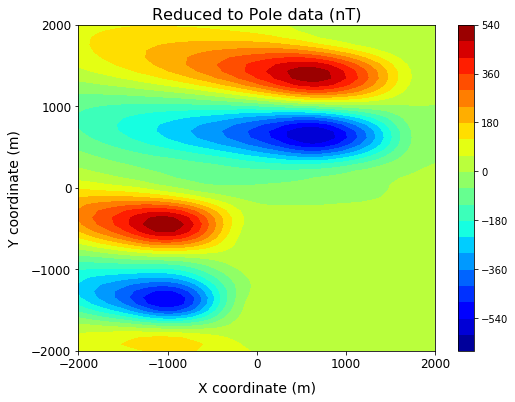

In [20]:
# Plotting the result
pyplot.figure(figsize=(8, 6))
pyplot.contourf(yobs.reshape(shape), xobs.reshape(shape), rtp1_eqlayer.reshape(shape), 
                20, cmap = pyplot.cm.jet)
# Draw the model edges
#draw_prism(dike1[:4], linewidth=1., style = 'k.--' , label = 'Model 1')
#draw_prism(dike2[:4], linewidth=1., style = 'k-.', label = 'Model 2')
pyplot.title('Reduced to Pole data (nT)', fontsize = 16)
pyplot.xlabel('X coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('Y coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yobs.min(), yobs.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xobs.min(), xobs.max(), 5), fontsize = 12)
pyplot.colorbar(orientation = 'vertical')
#pyplot.legend(loc = 'upper left', fontsize = 'x-large')

pyplot.savefig('figname.png', dpi = 300, bbox_inches = 'tight')
pyplot.show()

### Step 2 - Compute the cross-correlation coefficients at all positive values of inclination greater than $10^o$

In [21]:
# Compute the time
initial = time()
for k2, d in enumerate(declination):
    for k1, i in enumerate(inclination2):    
        rtp = reduction(xobs, yobs, tf, inc, dec, i, d)
        tga = totalgrad(xobs, yobs, rtp)
        vga = zderiv(xobs, yobs, rtp)
        res2[k1,k2] = cccoef(tga, vga)        
final = time()
print 'Cross correlation for negative range'
print 'Computation time (sec): %.3f' % (final-initial)

Cross correlation for negative range
Computation time (sec): 36.234


In [22]:
# Analysing the negative coefficients
print 'Second cross-correlation:'
_ = analysis(res2, 'no unit')

Second cross-correlation:
Minimum:    -0.1514 no unit
Maximum:    0.5046 no unit
Mean value: 0.2382 no unit
Variation:  0.6560 no unit


In [23]:
# Search for the maximum and minimum pair of inclination and declination
imax2, jmax2 = numpy.where(res2 == res2.max())
imin2, jmin2 = numpy.where(res2 == res2.min())
incmax2 = float(I2[imax2, jmax2])
decmax2 = float(D2[imax2, jmax2])
incmin2 = float(I2[imin2, jmin2])
decmin2 = float(D2[imin2, jmin2])
print 'Verify the computed anticorrelation:'
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax2
print 'Declination:', decmax2
print
print '(I,D) for minimum coefficient:'
print 'Inclination:', incmin2
print 'Declination:', decmin2

Verify the computed anticorrelation:
(I,D) for maximum coefficient
Inclination: 10.0
Declination: 39.0

(I,D) for minimum coefficient:
Inclination: 10.0
Declination: -85.0


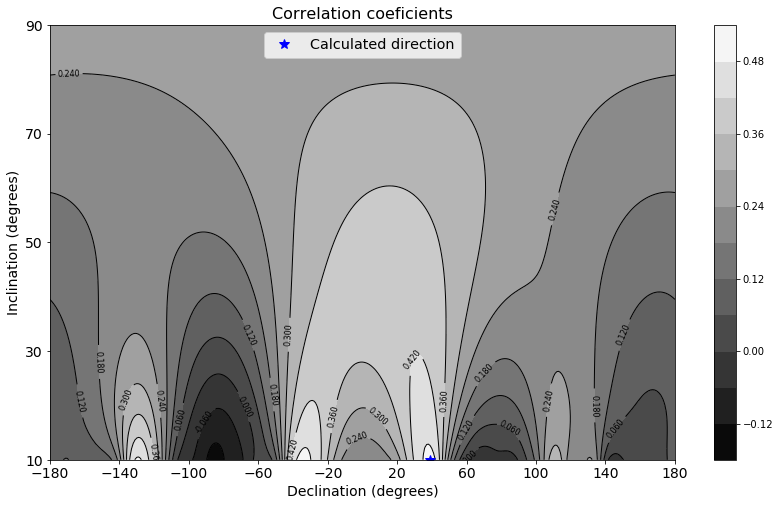

In [24]:
# Plotting the correlation results
pyplot.figure(figsize=(14, 8))

fig2 = pyplot.contour(D2, I2, res2, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(D2, I2, res2,10, cmap = pyplot.cm.gray)
pyplot.clabel(fig2, fontsize = 8)
pyplot.rcParams['contour.negative_linestyle'] = 'solid'
pyplot.plot(decmax2, incmax2, 'b*', markersize = 10, label = 'Calculated direction')
pyplot.title('Correlation coeficients', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.linspace(D2.min(), D2.max(), 10), fontsize = 14)
pyplot.yticks(numpy.linspace(I2.min(), I2.max(), 5), fontsize = 14)
pyplot.legend(loc = 'upper center', fontsize = 'x-large')
pyplot.colorbar()
pyplot.savefig('fig03-second-correlation.png', dpi = 300, bbox_inches = 'tight')

pyplot.show()

In [25]:
# Computes the reduced data by equivalent layer (space domain)
rtp2_eqlayer = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, incmax2, decmax2)

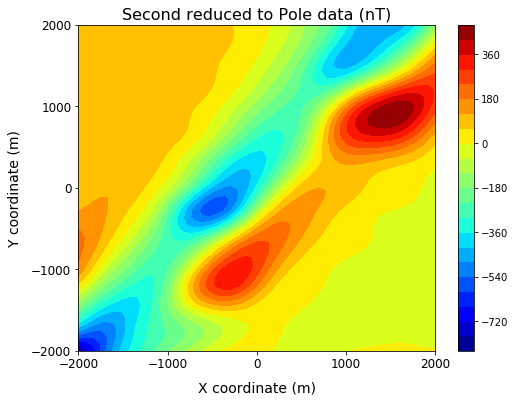

In [26]:
# Plotting the result
pyplot.figure(figsize=(8, 6))
pyplot.contourf(yobs.reshape(shape), xobs.reshape(shape), rtp2_eqlayer.reshape(shape), 
                20, cmap = pyplot.cm.jet)
# Draw the model edges
#draw_prism(dike1[:4], linewidth=1., style = 'k.--' , label = 'Model 1')
#draw_prism(dike2[:4], linewidth=1., style = 'k-.', label = 'Model 2')
pyplot.title('Second reduced to Pole data (nT)', fontsize = 16)
pyplot.xlabel('X coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('Y coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yobs.min(), yobs.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xobs.min(), xobs.max(), 5), fontsize = 12)
pyplot.colorbar(orientation = 'vertical')
#pyplot.legend(loc = 'upper left', fontsize = 'x-large')

pyplot.savefig('figname.png', dpi = 300, bbox_inches = 'tight')
pyplot.show()

### Step 3 - Compute the cross-correlation coefficients at low latitude areas

In [27]:
# For the Equivalent layer transformation
inc3 = numpy.linspace(-15., 15., 16)
dec3 = numpy.linspace(-90., 90., 31)

In [28]:
# Create the grid
D3, I3 = numpy.meshgrid(dec3, inc3)

In [29]:
# Create the zero matrix
res3 = numpy.zeros_like(D3)

In [30]:
# Compute time
initial = time()
for k2, d in enumerate(dec3):
    for k1, i in enumerate(inc3):    
        rtp = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, i, d)
        tga = totalgrad(xobs, yobs, rtp)
        vga = zderiv(xobs, yobs, rtp)
        res3[k1,k2] = cccoef(tga, vga)        
final = time()
print 'Cross correlation by equivalent layer'
print 'Computation time (sec): %.3f' % (final-initial)

Cross correlation by equivalent layer
Computation time (sec): 396.459


In [31]:
# Analysing the positive coefficients
print 'Third correlation (equivalent layer):'
_ = analysis(res3, 'no unit')

Third correlation (equivalent layer):
Minimum:    -0.2814 no unit
Maximum:    0.6677 no unit
Mean value: 0.0890 no unit
Variation:  0.9491 no unit


In [32]:
# Search for the maximum and minimum pair of inclination and declination
imax3, jmax3 = numpy.where(res3 == res3.max())
imin3, jmin3 = numpy.where(res3 == res3.min())
incmax3 = float(I3[imax3, jmax3])
decmax3 = float(D3[imax3, jmax3])
incmin3 = float(I3[imin3, jmin3])
decmin3 = float(D3[imin3, jmin3])
print 'Verify correlation by equivalent layer:'
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax3
print 'Declination:', decmax3
print
print '(I,D) for minimum coefficient:'
print 'Inclination:', incmin3
print 'Declination:', decmin3

Verify correlation by equivalent layer:
(I,D) for maximum coefficient
Inclination: 5.0
Declination: 0.0

(I,D) for minimum coefficient:
Inclination: 1.0
Declination: 42.0


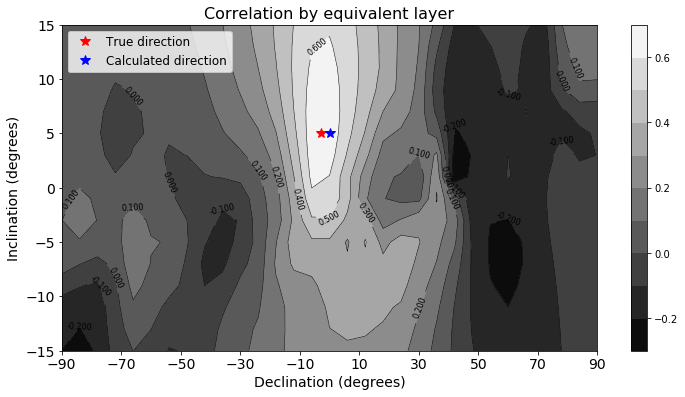

In [33]:
# Plotting the correlation results
pyplot.figure(figsize=(12, 6))
fig3 = pyplot.contour(D3, I3, res3, 10, colors = 'k', linestyle = 'solid', linewidths = 0.5)
pyplot.contourf(D3, I3, res3, 10, cmap = pyplot.cm.gray)
pyplot.plot(decs, incs, 'r*', markersize = 10, label = 'True direction')
pyplot.plot(decmax3, incmax3, 'b*', markersize = 10, label = 'Calculated direction')
pyplot.clabel(fig3, fontsize = 8)
pyplot.rcParams['contour.negative_linestyle'] = 'solid'
pyplot.title('Correlation by equivalent layer', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.linspace(D3.min(), D3.max(), 10), fontsize = 14)
pyplot.yticks(numpy.linspace(I3.min(), I3.max(), 7), fontsize = 14)
pyplot.legend(loc = 'upper left', fontsize = 'large')
pyplot.colorbar()
pyplot.savefig('fig04-third-correlation.png', dpi = 300, bbox_inches = 'tight')

pyplot.show()

In [34]:
# Computes the reduced data by equivalent layer (space domain)
rtp3_eqlayer = rtp_layer(data, shape, eqlayer, shape_layer, inc, dec, incmax3, decmax3)

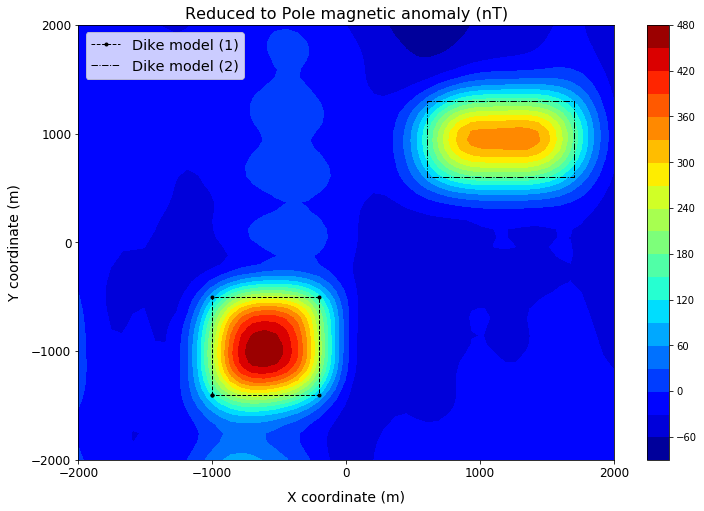

In [35]:
# Plotting the result
pyplot.figure(figsize=(12, 8))
pyplot.contourf(yobs.reshape(shape), xobs.reshape(shape), rtp3_eqlayer.reshape(shape), 
                20, cmap = pyplot.cm.jet)
draw_prism(dike1[:4], linewidth=1., style = 'k.--', label = 'Dike model (1)', xy2ne=True)
draw_prism(dike2[:4], linewidth=1., style = 'k-.', label = 'Dike model (2)', xy2ne=True)
pyplot.legend(loc = 'upper left', fontsize = 'x-large')
pyplot.title('Reduced to Pole magnetic anomaly (nT)', fontsize = 16)
pyplot.xlabel('X coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('Y coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yobs.min(), yobs.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xobs.min(), xobs.max(), 5), fontsize = 12)
pyplot.colorbar(orientation = 'vertical')

pyplot.savefig('fig05-reducedtopole.png', dpi = 300, bbox_inches = 'tight')
pyplot.show()

# Test for diferent magnetization directions

In [36]:
xobs = xobs.reshape(nx*ny)
yobs = yobs.reshape(nx*ny)
zobs = zobs.reshape(nx*ny)

In [37]:
# Computes the total field anomaly
tfa = prism_tf(xobs, yobs, zobs, dike1, inc, dec, incs, decs) + \
      prism_tf(xobs, yobs, zobs, dike2, inc, dec, incs - 12., decs - 16.)

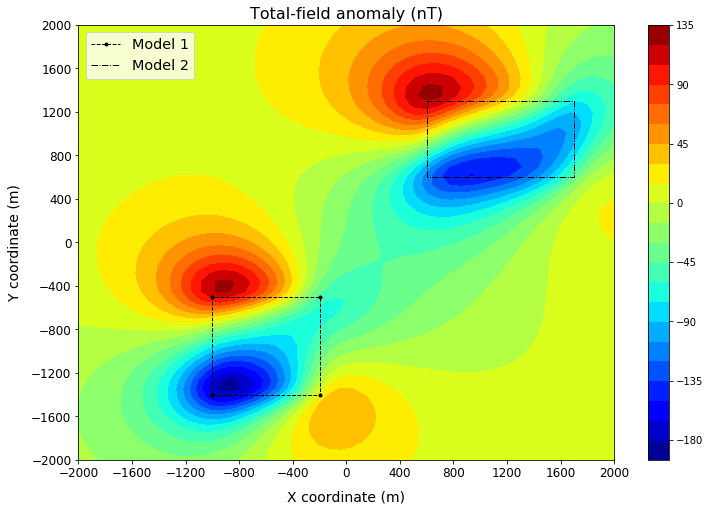

In [38]:
# Plotting the result
pyplot.figure(figsize=(12, 8))
pyplot.contourf(yobs.reshape(shape), xobs.reshape(shape), tfa.reshape(shape), 
                20, cmap = pyplot.cm.jet)
# Draw the model edges
draw_prism(dike1[:4], linewidth=1., style = 'k.--' , label = 'Model 1', xy2ne=True)
draw_prism(dike2[:4], linewidth=1., style = 'k-.', label = 'Model 2', xy2ne=True)
pyplot.title('Total-field anomaly (nT)', fontsize = 16)
pyplot.xlabel('X coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('Y coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yobs.min(), yobs.max(), 11), fontsize = 12)
pyplot.yticks(numpy.linspace(xobs.min(), xobs.max(), 11), fontsize = 12)
pyplot.colorbar(orientation = 'vertical')
pyplot.legend(loc = 'upper left', fontsize = 'x-large')

pyplot.savefig('fig05-totalfieldanomaly(2).png', dpi = 300, bbox_inches = 'tight')
pyplot.show()

In [39]:
newdata = [xobs, yobs, zobs, tfa]

In [40]:
# Create the zero matrix
Res1 = numpy.zeros_like(D1)
Res2 = numpy.zeros_like(D2)

In [41]:
# Reshape the data as grid format
xobs = xobs.reshape(shape)
yobs = yobs.reshape(shape)
tfa = tfa.reshape(shape)

In [42]:
# Compute the time
initial = time()
for k2, d in enumerate(declination):
    for k1, i in enumerate(inclination1):
        rtp = reduction(xobs, yobs, tfa, inc, dec, i, d)
        tga = totalgrad(xobs, yobs, rtp)
        vga = zderiv(xobs, yobs, rtp)
        Res1[k1,k2] = cccoef(tga, vga)        
final = time()
print 'Cross correlation for positive range'
print 'Computation time (sec): %.3f' % (final-initial)

Cross correlation for positive range
Computation time (sec): 42.063


In [43]:
# Analysing the positive coefficients
print 'First cross-correlation:'
_ = analysis(Res1, 'no unit')

First cross-correlation:
Minimum:    -0.5371 no unit
Maximum:    0.3166 no unit
Mean value: -0.1187 no unit
Variation:  0.8537 no unit


In [44]:
# Search for the maximum and minimum pair of inclination and declination
imax1, jmax1 = numpy.where(Res1 == Res1.max())
imin1, jmin1 = numpy.where(Res1 == Res1.min())
incmax1 = float(I1[imax1, jmax1])
decmax1 = float(D1[imax1, jmax1])
incmin1 = float(I1[imin1, jmin1])
decmin1 = float(D1[imin1, jmin1])
print 'Verify the computed correlation:'
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax1
print 'Declination:', decmax1
print
print '(I,D) for minimum coefficient:'
print 'Inclination:', incmin1
print 'Declination:', decmin1

Verify the computed correlation:
(I,D) for maximum coefficient
Inclination: -10.0
Declination: 87.0

(I,D) for minimum coefficient:
Inclination: -10.0
Declination: -140.0


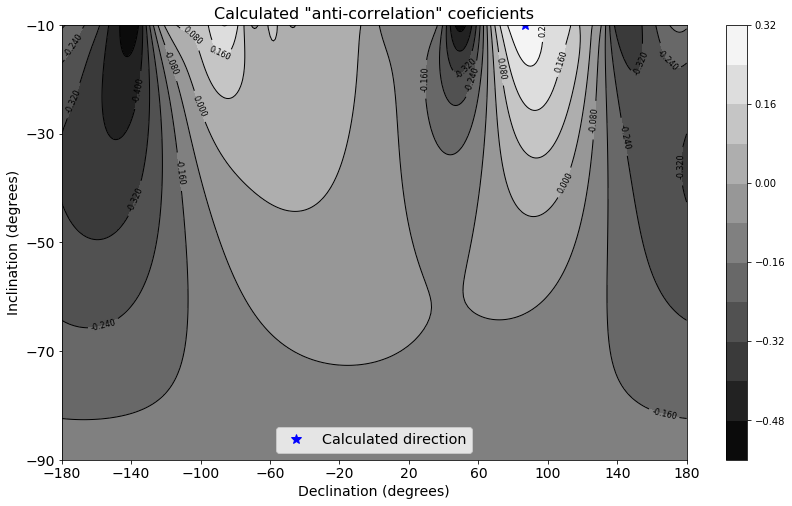

In [45]:
# Plotting the correlation results
pyplot.figure(figsize=(14, 8))

fig1 = pyplot.contour(D1, I1, Res1, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(D1, I1, Res1, 10, cmap = pyplot.cm.gray)
pyplot.clabel(fig1, fontsize = 8)
pyplot.plot(decmax1, incmax1, 'b*', markersize = 10, label = 'Calculated direction')
pyplot.rcParams['contour.negative_linestyle'] = 'solid'
pyplot.title('Calculated "anti-correlation" coeficients', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.linspace(D1.min(), D1.max(), 10), fontsize = 14)
pyplot.yticks(numpy.linspace(I1.min(), I1.max(), 5), fontsize = 14)
pyplot.legend(loc = 'lower center', fontsize = 'x-large')
pyplot.colorbar()
pyplot.savefig('fig07-first-correlation(1).png', dpi = 300, bbox_inches = 'tight')

pyplot.show()

In [46]:
# Computes the reduced data by equivalent layer (space domain)
rtp1_eqlayer = rtp_layer(newdata, shape, eqlayer, shape_layer, inc, dec, incmax1, decmax1)

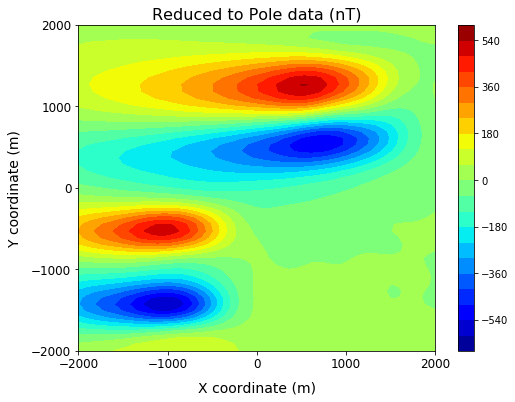

In [47]:
# Plotting the result
pyplot.figure(figsize=(8, 6))
pyplot.contourf(yobs.reshape(shape), xobs.reshape(shape), rtp1_eqlayer.reshape(shape), 
                20, cmap = pyplot.cm.jet)
pyplot.title('Reduced to Pole data (nT)', fontsize = 16)
pyplot.xlabel('X coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('Y coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yobs.min(), yobs.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xobs.min(), xobs.max(), 5), fontsize = 12)
pyplot.colorbar(orientation = 'vertical')
pyplot.show()

In [48]:
# Compute the time
initial = time()
for k2, d in enumerate(declination):
    for k1, i in enumerate(inclination2):    
        rtp = reduction(xobs, yobs, tfa, inc, dec, i, d)
        tga = totalgrad(xobs, yobs, rtp)
        vga = zderiv(xobs, yobs, rtp)
        Res2[k1,k2] = cccoef(tga, vga)        
final = time()
print 'Cross correlation for negative range'
print 'Computation time (sec): %.3f' % (final-initial)

Cross correlation for negative range
Computation time (sec): 38.684


In [49]:
# Analysing the negative coefficients
print 'Second cross-correlation:'
_ = analysis(Res2, 'no unit')

Second cross-correlation:
Minimum:    -0.3166 no unit
Maximum:    0.5371 no unit
Mean value: 0.1182 no unit
Variation:  0.8537 no unit


In [50]:
# Search for the maximum and minimum pair of inclination and declination
imax2, jmax2 = numpy.where(Res2 == Res2.max())
imin2, jmin2 = numpy.where(Res2 == Res2.min())
incmax2 = float(I2[imax2, jmax2])
decmax2 = float(D2[imax2, jmax2])
incmin2 = float(I2[imin2, jmin2])
decmin2 = float(D2[imin2, jmin2])
print 'Verify the computed anticorrelation:'
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax2
print 'Declination:', decmax2
print
print '(I,D) for minimum coefficient:'
print 'Inclination:', incmin2
print 'Declination:', decmin2

Verify the computed anticorrelation:
(I,D) for maximum coefficient
Inclination: 10.0
Declination: 40.0

(I,D) for minimum coefficient:
Inclination: 10.0
Declination: -93.0


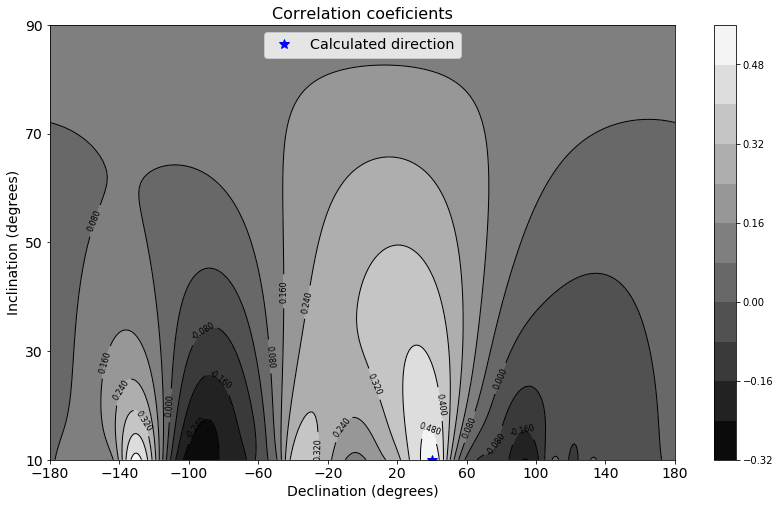

In [51]:
# Plotting the correlation results
pyplot.figure(figsize=(14, 8))

fig2 = pyplot.contour(D2, I2, Res2, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.contourf(D2, I2, Res2,10, cmap = pyplot.cm.gray)
pyplot.clabel(fig2, fontsize = 8)
pyplot.rcParams['contour.negative_linestyle'] = 'solid'
pyplot.plot(decmax2, incmax2, 'b*', markersize = 10, label = 'Calculated direction')
pyplot.title('Correlation coeficients', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.linspace(D2.min(), D2.max(), 10), fontsize = 14)
pyplot.yticks(numpy.linspace(I2.min(), I2.max(), 5), fontsize = 14)
pyplot.legend(loc = 'upper center', fontsize = 'x-large')
pyplot.colorbar()
pyplot.savefig('fig08-second-correlation(2).png', dpi = 300, bbox_inches = 'tight')

pyplot.show()

In [52]:
# Computes the reduced data by equivalent layer (space domain)
rtp2_eqlayer = rtp_layer(newdata, shape, eqlayer, shape_layer, inc, dec, incmax2, decmax2)

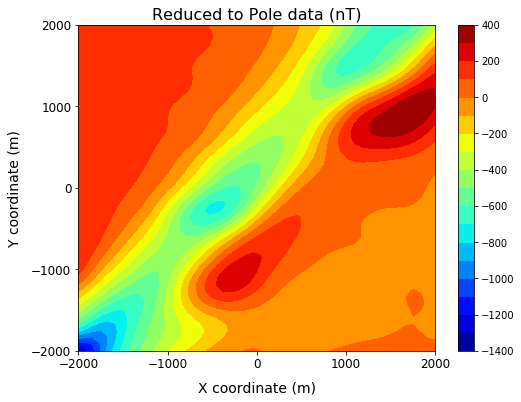

In [53]:
# Plotting the result
pyplot.figure(figsize=(8, 6))
pyplot.contourf(yobs.reshape(shape), xobs.reshape(shape), rtp2_eqlayer.reshape(shape), 
                20, cmap = pyplot.cm.jet)
pyplot.title('Reduced to Pole data (nT)', fontsize = 16)
pyplot.xlabel('X coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('Y coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yobs.min(), yobs.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xobs.min(), xobs.max(), 5), fontsize = 12)
pyplot.colorbar(orientation = 'vertical')
pyplot.show()

In [54]:
# Create the zero matrix
Res3 = numpy.zeros_like(D3)

In [55]:
# Compute time
initial = time()
for k2, d in enumerate(dec3):
    for k1, i in enumerate(inc3):    
        rtp = rtp_layer(newdata, shape, eqlayer, shape_layer, inc, dec, i, d)
        tga = totalgrad(xobs, yobs, rtp)
        vga = zderiv(xobs, yobs, rtp)
        Res3[k1,k2] = cccoef(tga, vga)        
final = time()
print 'Cross correlation by equivalent layer'
print 'Computation time (sec): %.3f' % (final-initial)

Cross correlation by equivalent layer
Computation time (sec): 392.498


In [56]:
# Analysing the positive coefficients
print 'Third correlation (equivalent layer):'
_ = analysis(Res3, 'no unit')

Third correlation (equivalent layer):
Minimum:    -0.2719 no unit
Maximum:    0.4672 no unit
Mean value: 0.0733 no unit
Variation:  0.7391 no unit


In [57]:
# Search for the maximum and minimum pair of inclination and declination
imax3, jmax3 = numpy.where(Res3 == Res3.max())
imin3, jmin3 = numpy.where(Res3 == Res3.min())
incmax3 = float(I3[imax3, jmax3])
decmax3 = float(D3[imax3, jmax3])
incmin3 = float(I3[imin3, jmin3])
decmin3 = float(D3[imin3, jmin3])
print 'Verify correlation by equivalent layer:'
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax3
print 'Declination:', decmax3
print
print '(I,D) for minimum coefficient:'
print 'Inclination:', incmin3
print 'Declination:', decmin3

Verify correlation by equivalent layer:
(I,D) for maximum coefficient
Inclination: -1.0
Declination: -6.0

(I,D) for minimum coefficient:
Inclination: 1.0
Declination: 42.0


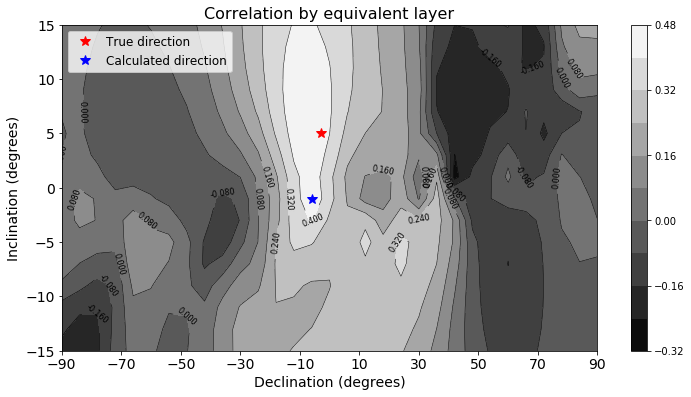

In [58]:
# Plotting the correlation results
pyplot.figure(figsize=(12, 6))
fig3 = pyplot.contour(D3, I3, Res3, 10, colors = 'k', linestyle = 'solid', linewidths = 0.5)
pyplot.contourf(D3, I3, Res3, 10, cmap = pyplot.cm.gray)
pyplot.plot(decs, incs, 'r*', markersize = 10, label = 'True direction')
pyplot.plot(decmax3, incmax3, 'b*', markersize = 10, label = 'Calculated direction')
pyplot.clabel(fig3, fontsize = 8)
pyplot.rcParams['contour.negative_linestyle'] = 'solid'
pyplot.title('Correlation by equivalent layer', fontsize = 16)
pyplot.xlabel('Declination (degrees)', fontsize = 14)
pyplot.ylabel('Inclination (degrees)', fontsize = 14)
pyplot.xticks(numpy.linspace(D3.min(), D3.max(), 10), fontsize = 14)
pyplot.yticks(numpy.linspace(I3.min(), I3.max(), 7), fontsize = 14)
pyplot.legend(loc = 'upper left', fontsize = 'large')
pyplot.colorbar()
pyplot.savefig('fig09-third-correlation(2).png', dpi = 300, bbox_inches = 'tight')

pyplot.show()

In [59]:
# Computes the reduced data by equivalent layer (space domain)
rtp3_eqlayer = rtp_layer(newdata, shape, eqlayer, shape_layer, inc, dec, incmax3, decmax3)

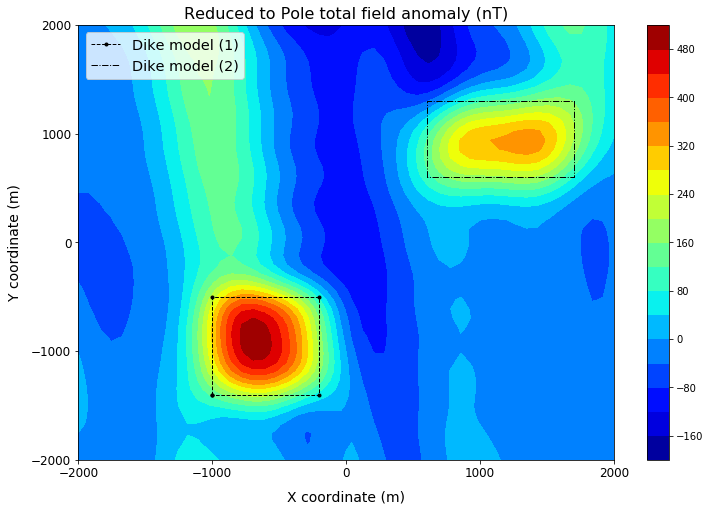

In [60]:
# Plotting the result
pyplot.figure(figsize=(12, 8))
pyplot.contourf(yobs.reshape(shape), xobs.reshape(shape), rtp3_eqlayer.reshape(shape), 
                20, cmap = pyplot.cm.jet)
draw_prism(dike1[:4], linewidth=1., style = 'k.--', label = 'Dike model (1)', xy2ne=True)
draw_prism(dike2[:4], linewidth=1., style = 'k-.', label = 'Dike model (2)', xy2ne=True)
pyplot.legend(loc = 'upper left', fontsize = 'x-large')
pyplot.title('Reduced to Pole total field anomaly (nT)', fontsize = 16)
pyplot.xlabel('X coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.ylabel('Y coordinate (m)', fontsize = 14, labelpad = 10)
pyplot.xticks(numpy.linspace(yobs.min(), yobs.max(), 5), fontsize = 12)
pyplot.yticks(numpy.linspace(xobs.min(), xobs.max(), 5), fontsize = 12)
pyplot.colorbar(orientation = 'vertical')

pyplot.savefig('fig10-reducedtopole(2).png', dpi = 300, bbox_inches = 'tight')
pyplot.show()